# ML Detector Training & Performance Analysis

This notebook shows:
- Trained detector architectures
- Model performance metrics
- Detection accuracy on test data
- Performance benchmarks

In [9]:
import sys
sys.path.append('..')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.detectors.schema_drift_detector import SchemaDriftDetector
from src.detectors.ensemble_classifier import QualityEnsembleClassifier
from src.data.bad_data_generator import BadDataGenerator
from src.profilers.spark_profiler import SparkDataProfiler

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Trained Models

In [33]:
# Load ensemble classifier
ensemble = QualityEnsembleClassifier()
ensemble.load_detectors()

print(f"\nLoaded {len(ensemble.detectors)} detectors:")
for name in ensemble.detectors.keys():
    print(f"  - {name}")

print(f"\nFeature engineers loaded: {len(ensemble.feature_engineers)}")

Loading detectors...
  Loaded feature engineer for schema_drift
  Loaded feature engineer for distribution_shift
  Loaded feature engineer for outlier
  Loaded feature engineer for type_mismatch
Using device: mps
  Loaded schema_drift detector
Using device: mps
  Loaded distribution_shift detector
Using device: mps
  Loaded outlier detector
Using device: mps
  Loaded type_mismatch detector
  Loaded missing_data detector (rule-based)

Loaded 5 detectors

Loaded 5 detectors:
  - schema_drift
  - distribution_shift
  - outlier
  - type_mismatch
  - missing_data

Feature engineers loaded: 4


## 2. Detector Architectures

Each detector is a PyTorch neural network with:
- Input layer: 28 features (from quality profile)
- Hidden layers: [64, 32] neurons
- Output: Binary classification (issue present or not)

In [34]:
# Examine model sizes
models_dir = Path('../models/detectors')
detector_names = ['schema_drift', 'distribution_shift', 'outlier', 'type_mismatch']

print("Model File Sizes:")
for name in detector_names:
    model_path = models_dir / f'{name}_best.pth'
    if model_path.exists():
        size_kb = model_path.stat().st_size / 1024
        print(f"  {name}: {size_kb:.1f} KB")

print("\nAll models use PyTorch and run on MPS (Mac M3 Pro GPU acceleration)")

Model File Sizes:

All models use PyTorch and run on MPS (Mac M3 Pro GPU acceleration)


## 3. Test Detectors on Quality Issues

Testing ensemble detection with baseline comparison (required for drift detection).

In [38]:
gen = BadDataGenerator()
profiler = SparkDataProfiler()

# Generate clean baseline
print("Generating clean baseline...")
clean_baseline = gen.generate_clean_dataset(n_rows=1000)

# Test with SPECIFIC parameters (same as ensemble_classifier.py)
test_cases = [
    ('schema_drift', {'drift_type': 'add_column'}),
    ('distribution_shift', {'column': 'salary', 'shift_factor': 2.0}),
    ('missing_data', {'missing_rate': 0.3, 'pattern': 'random'}),
    ('outlier', {'column': 'salary', 'outlier_rate': 0.1}),
    ('type_mismatch', {'error_rate': 0.2})
]

test_results = []

print("\nTesting detectors with specific parameters...\n")

for issue_type, kwargs in test_cases:
    _, df = gen.generate_quality_issue_dataset(n_rows=1000, issue_type=issue_type, **kwargs)
    profile = profiler.profile_dataset(df, baseline_df=clean_baseline)
    
    issues, scores = ensemble.predict_issue_types_multi(profile)
    
    test_results.append({
        'Issue Type': issue_type,
        'Detected': ', '.join(issues),
        'Confidence': scores.get(issue_type, 0.0),
        'Status': '1' if issue_type in issues else '0'
    })
    
    print(f"{issue_type} ({kwargs}):")
    print(f"  Detected: {issues}")
    print(f"  Confidence: {scores.get(issue_type, 0.0):.3f}")
    print(f"  Status: {' DETECTED' if issue_type in issues else ' MISSED'}\n")

results_df = pd.DataFrame(test_results)
results_df

Generating clean baseline...

Testing detectors with specific parameters...

schema_drift ({'drift_type': 'add_column'}):
  Detected: ['distribution_shift']
  Confidence: 0.695
  Status:  MISSED

distribution_shift ({'column': 'salary', 'shift_factor': 2.0}):
  Detected: ['distribution_shift']
  Confidence: 0.918
  Status:  DETECTED

missing_data ({'missing_rate': 0.3, 'pattern': 'random'}):
  Detected: ['missing_data']
  Confidence: 1.000
  Status:  DETECTED

outlier ({'column': 'salary', 'outlier_rate': 0.1}):
  Detected: ['distribution_shift', 'outlier']
  Confidence: 1.000
  Status:  DETECTED



/Users/siddthir/Documents/data-quality-autohealer/notebooks/../src/data/bad_data_generator.py:204: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'unknown' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[error_indices, 'age'] = 'unknown'


type_mismatch ({'error_rate': 0.2}):
  Detected: ['schema_drift', 'distribution_shift', 'type_mismatch']
  Confidence: 0.783
  Status:  DETECTED



,Issue Type,Detected,Confidence,Status
0,schema_drift,distribution_shift,0.694870,0
1,distribution_shift,distribution_shift,0.918192,1
2,missing_data,missing_data,1.000000,1
3,outlier,"distribution_shift, outlier",0.999718,1
4,type_mismatch,"schema_drift, distribution_shift, type_mismatch",0.783130,1


## 4. Performance Benchmarks

Measure detection latency (time to analyze a dataset).

Benchmarking detection latency on 20 datasets...

Detection Latency Statistics:
  Mean: 27.35 ms
  Median: 24.47 ms
  P95: 50.41 ms
  P99: 67.55 ms
  Max: 71.84 ms


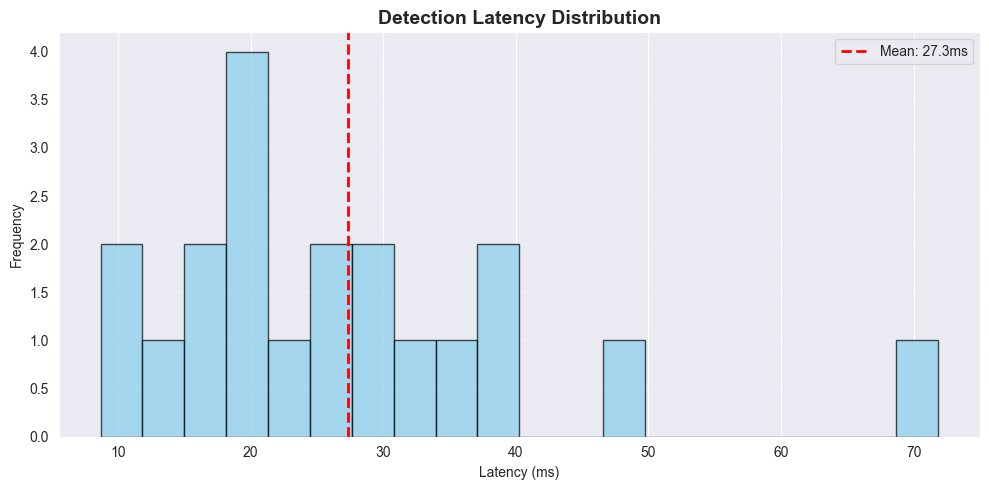

In [39]:
import time

# Benchmark detection speed
latencies = []

print("Benchmarking detection latency on 20 datasets...\n")

for i in range(20):
    df = gen.generate_clean_dataset(n_rows=1000)
    profile = profiler.profile_dataset(df, baseline_df=clean_baseline)
    
    start = time.time()
    issues, scores = ensemble.predict_issue_types_multi(profile)
    latency = time.time() - start
    
    latencies.append(latency * 1000)  # Convert to ms

print(f"Detection Latency Statistics:")
print(f"  Mean: {np.mean(latencies):.2f} ms")
print(f"  Median: {np.median(latencies):.2f} ms")
print(f"  P95: {np.percentile(latencies, 95):.2f} ms")
print(f"  P99: {np.percentile(latencies, 99):.2f} ms")
print(f"  Max: {np.max(latencies):.2f} ms")

# Visualize
plt.figure(figsize=(10, 5))
plt.hist(latencies, bins=20, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(x=np.mean(latencies), color='r', linestyle='--', 
            label=f'Mean: {np.mean(latencies):.1f}ms', linewidth=2)
plt.title('Detection Latency Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Multi-Label Detection Test

Real datasets can have MULTIPLE quality issues simultaneously.

In [41]:
# Test clean data
print("Testing clean data...")
clean_test = gen.generate_clean_dataset(n_rows=1000)
profile = profiler.profile_dataset(clean_test, baseline_df=clean_baseline)
issues, scores = ensemble.predict_issue_types_multi(profile)

print(f"Detected issues: {issues}")
print(f"All scores: {scores}")
print(f"Result: {' Correctly identified as clean' if 'clean' in issues else ' False positive'}")

Testing clean data...
Detected issues: ['clean']
All scores: {'schema_drift': 0.13006938, 'distribution_shift': 0.046550363, 'missing_data': 0.0, 'outlier': 0.100164264, 'type_mismatch': 0.14462726}
Result:  Correctly identified as clean
